In [23]:
import os
import glob
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate

/Users/human/.local/share/virtualenvs/nirs-analysis-cPFDHTrY/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Marker indexes -> [   63  1317  2484  3608  4769  5895  7046  8171  9357 10470]

Oxy-Hb data


,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0.000,0,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.150,0,,-0.010916,0.003867,0.006667,0.003237,0.002989,0.004922,0.004623,...,0.008919,0.003507,0.005177,0.002709,0.007292,0.003441,0.003417,0.008807,0.006464,0.002820
2,0.300,0,,0.001431,0.003377,0.007147,0.003741,0.002111,0.003658,0.005710,...,0.010347,0.002795,0.005039,0.005042,0.006374,0.002175,0.002802,0.010716,0.006633,0.002474
3,0.450,0,,-0.002045,0.001742,0.004772,0.002395,-0.003275,0.000927,0.003333,...,0.006198,0.000844,0.003133,0.001365,0.002798,0.000594,0.000109,0.007197,0.003833,-0.000237
4,0.600,0,,0.001474,0.000238,0.000823,-0.000762,-0.005549,-0.002680,-0.000588,...,0.000255,-0.001728,-0.001860,0.001166,-0.001348,-0.001288,-0.002298,0.002399,-0.000579,-0.002828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,1737.3,10,questionnaire,-0.071698,-0.058509,-0.042237,0.033209,-0.065773,0.063947,0.073778,...,-0.037005,-0.027884,0.006887,-0.015162,-0.029784,-0.028576,-0.009314,-0.06178,-0.00106,0.070055
11583,1737.45,10,questionnaire,-0.064951,-0.058814,-0.042617,0.030935,-0.067479,0.064016,0.071132,...,-0.040981,-0.027485,0.007266,-0.015991,-0.03161,-0.030835,-0.010556,-0.059402,-0.003844,0.06796
11584,1737.6,10,questionnaire,-0.066047,-0.060842,-0.045839,0.026885,-0.071183,0.065581,0.068064,...,-0.047664,-0.030606,0.004814,-0.017076,-0.035312,-0.032719,-0.011985,-0.054567,-0.009187,0.06607
11585,1737.75,10,questionnaire,-0.073903,-0.063848,-0.049477,0.024036,-0.073848,0.067346,0.066408,...,-0.053574,-0.032306,0.001804,-0.023427,-0.040371,-0.037321,-0.015537,-0.04871,-0.014751,0.063313


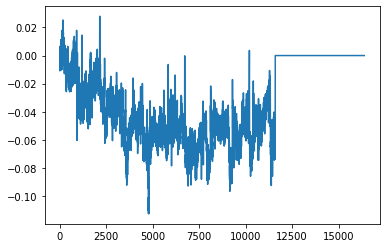

Denoised Oxy-Hb data


,time,trial_count,trial_category,ch-1,ch-2,ch-3,ch-4,ch-5,ch-6,ch-7,...,ch-13,ch-14,ch-15,ch-16,ch-17,ch-18,ch-19,ch-20,ch-21,ch-22
0,0.000,0,,-0.0222666,-0.0109878,0.0137644,0.0072993,-0.0449387,-0.0138504,0.0530572,...,0.00231739,-0.00784504,0.0467403,0.0130691,0.0106454,-0.0100606,0.00691837,0.00641273,0.00308836,0.0301587
1,0.150,0,,-0.0223517,-0.0110178,0.013724,0.00727689,-0.0451182,-0.0138993,0.0530629,...,0.00217569,-0.0078592,0.0468353,0.0130803,0.010636,-0.0101803,0.00688267,0.00637792,0.00296858,0.0301756
2,0.300,0,,-0.0224368,-0.0110481,0.0136839,0.00725469,-0.045297,-0.0139482,0.0530689,...,0.0020346,-0.00787371,0.0469295,0.0130913,0.0106263,-0.0102992,0.00684725,0.00634288,0.00284934,0.0301924
3,0.450,0,,-0.0225218,-0.0110787,0.0136439,0.0072327,-0.045475,-0.0139969,0.0530752,...,0.00189411,-0.00788856,0.047023,0.013102,0.0106164,-0.0104175,0.00681211,0.00630762,0.00273062,0.0302089
4,0.600,0,,-0.0226068,-0.0111095,0.0136042,0.00721094,-0.0456523,-0.0140454,0.0530816,...,0.00175422,-0.00790376,0.0471158,0.0131125,0.0106062,-0.010535,0.00677726,0.00627213,0.00261243,0.0302253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11582,1737.3,10,questionnaire,-0.144189,-0.116891,-0.0663012,0.0717032,-0.156909,0.0578707,0.200117,...,-0.0402471,-0.0291185,0.00787427,0.0527089,-0.0116319,-0.0267207,-0.0352158,-0.140187,0.0662276,0.13666
11583,1737.45,10,questionnaire,-0.143909,-0.11668,-0.0661975,0.0715606,-0.156603,0.0577459,0.199694,...,-0.0402362,-0.0290938,0.00787098,0.0525328,-0.0116794,-0.0267217,-0.0351372,-0.139969,0.0660176,0.136416
11584,1737.6,10,questionnaire,-0.143629,-0.116469,-0.0660933,0.0714181,-0.156297,0.0576209,0.199271,...,-0.0402247,-0.0290692,0.00786747,0.0523571,-0.0117264,-0.0267218,-0.0350582,-0.139751,0.0658079,0.136172
11585,1737.75,10,questionnaire,-0.143348,-0.116258,-0.0659884,0.0712757,-0.15599,0.0574958,0.198848,...,-0.0402127,-0.0290447,0.00786376,0.0521817,-0.0117729,-0.0267211,-0.034979,-0.139531,0.0655986,0.135927


1


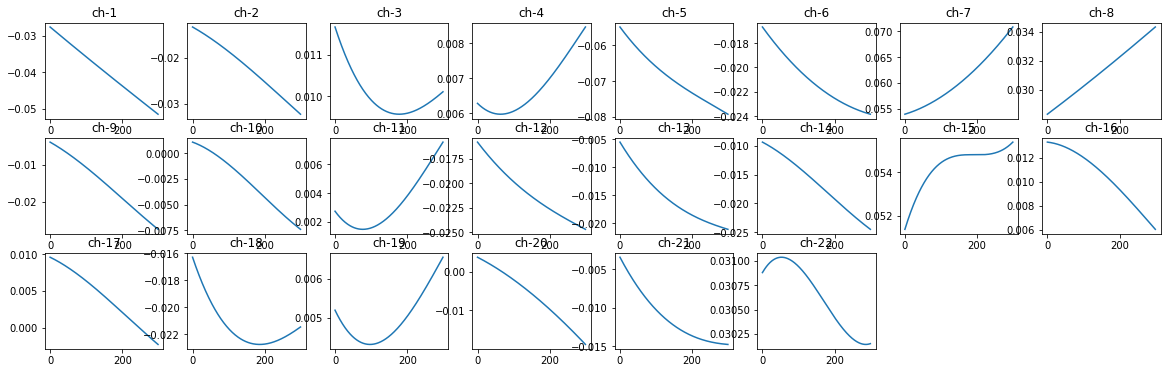





2


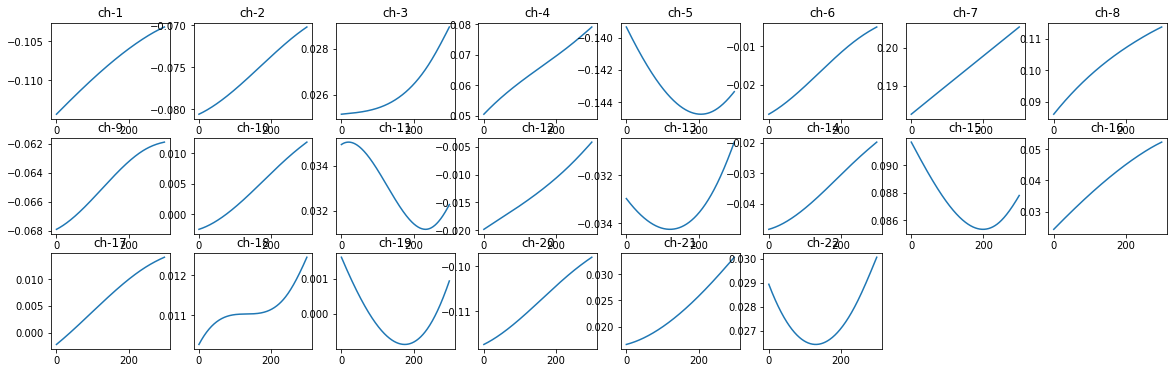





3


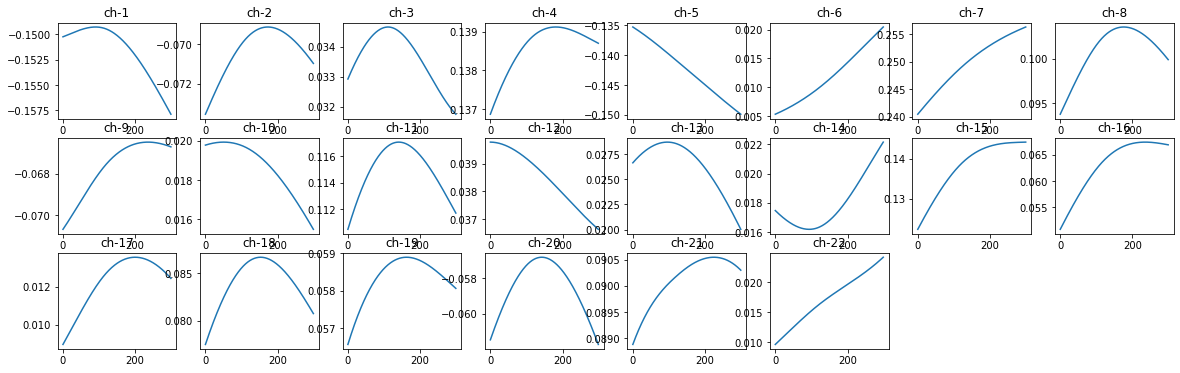





4


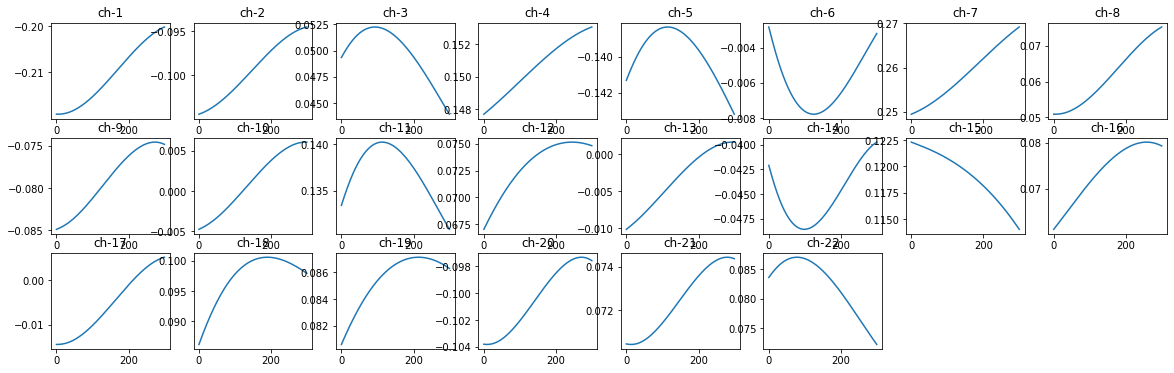





5


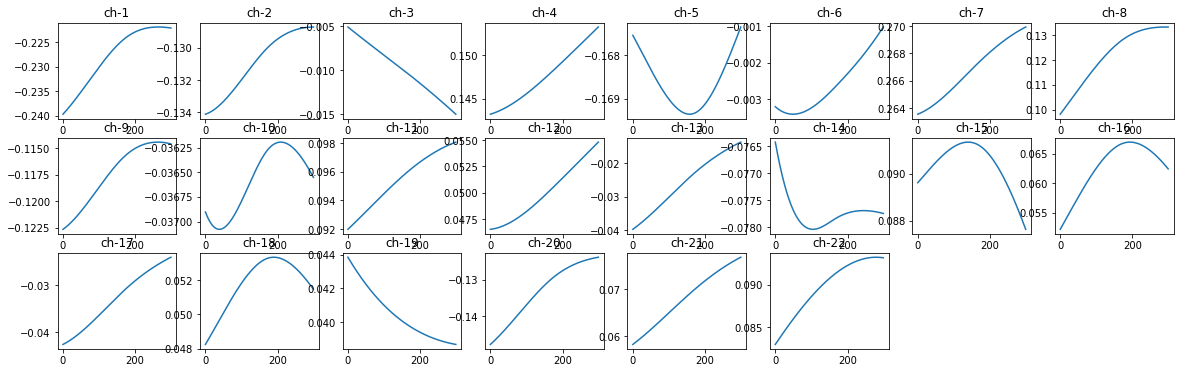





6


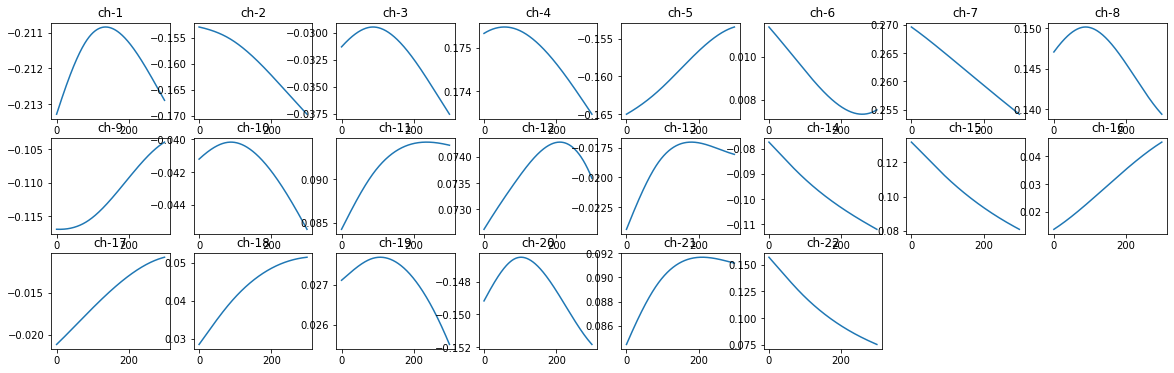





7


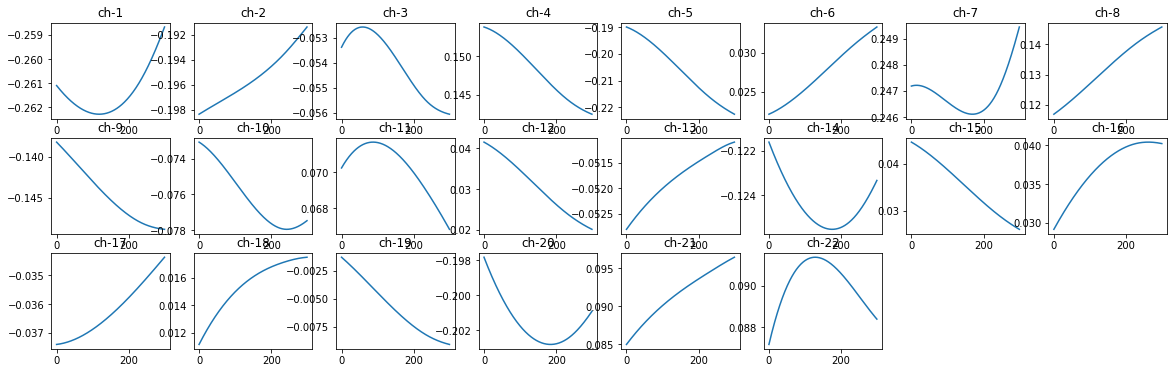





8


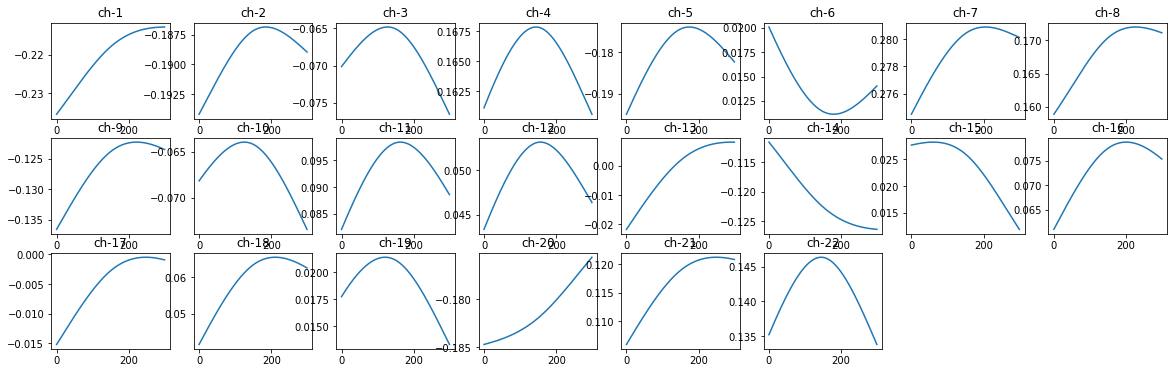





9


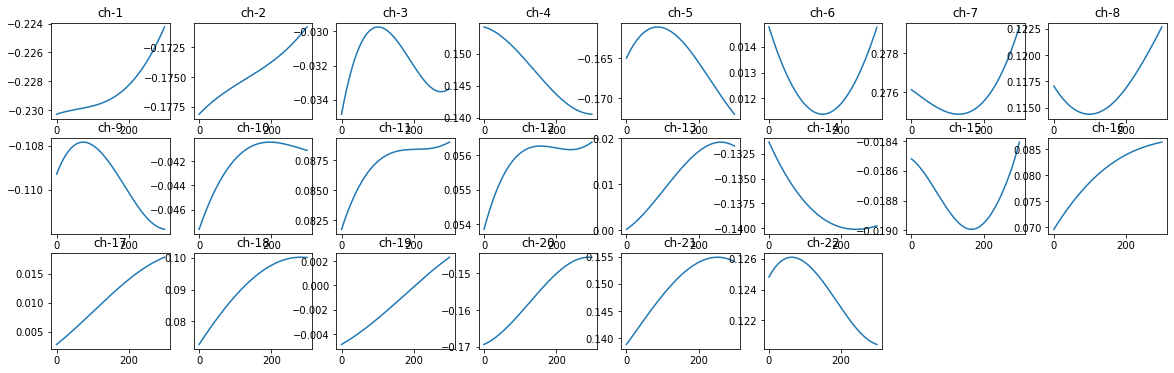





10


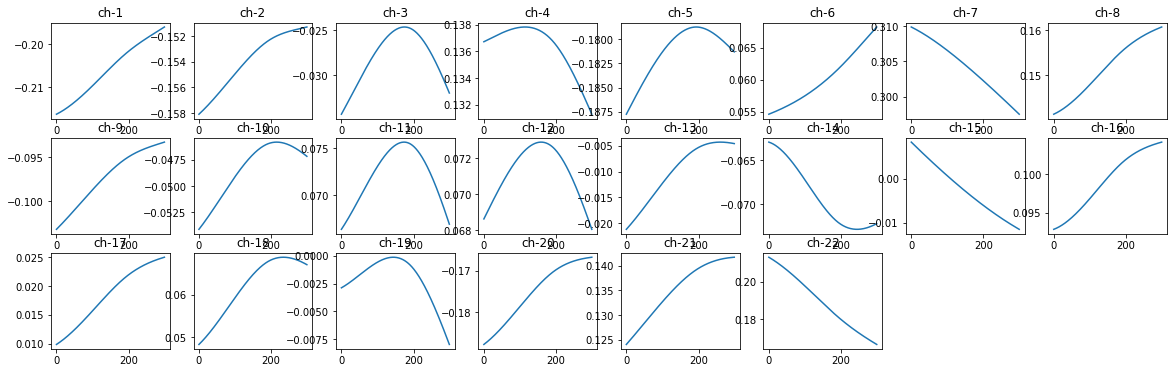

In [60]:
# define constants.
measurement_period = 0.15     # [sec]
preceding_rest_duration = 45  # [sec]
task_duration = 30            # [sec]
following_rest_duration = 45  # [sec]
num_preceding_rest_samples = int(preceding_rest_duration/measurement_period)
num_task_samples = int(task_duration/measurement_period)
num_following_rest_samples = int(following_rest_duration/measurement_period)
num_trial_samples = num_preceding_rest_samples + num_task_samples + num_following_rest_samples
num_columns = 70
separation_char = '\t'
data_table_start_row_index = 33
# marker_string = "1"
nirs_data_filepath = './experimental_data/nirs/0713-main.TXT'
questionnaire_data_filepath = './experimental_data/questionnaire/0713.csv'

# load nirs data and make (temporary) dataframe object
temporary_names = np.arange(num_columns).astype(str)
temporary_df = pd.read_csv(nirs_data_filepath, names=temporary_names, sep=separation_char)
# print("temporary dataframe")
# display(temporary_df)

# load questionnare data and create dataframe object
questionnaire_df = pd.read_csv(questionnaire_data_filepath, index_col=0)
questionnaire_df.insert(0, 'trial_count', (np.arange(len(questionnaire_df))+1).astype(str))
# print('\nQuestionnaire results')
# display(questionnaire_df)

# create dataframe object that contains oxy-hb data
oxy_data = temporary_df[[temporary_names[0], temporary_names[2], *temporary_names[4::3]]][data_table_start_row_index:].values
channel_names = [label.replace(' ', '') for label in oxy_data[0][2:]]
oxy_df_column_labels = [*oxy_data[1][:2], *channel_names]
oxy_df = pd.DataFrame(oxy_data[2:], columns=oxy_df_column_labels)
cast_dict = {}
for channel_name in channel_names:
    cast_dict[channel_name] = float
oxy_df.astype(cast_dict)

# find marker index where its value is not equal to <marker_string>
finding_marker_query_statement = 'Mark !=0 and Mark !="0"'
marker_indexes = oxy_df.query(finding_marker_query_statement).index.values
marker_differences = marker_indexes[1:] - marker_indexes[:-1]
marker_period_threshold = 120/measurement_period
valid_marker_boolean_indexes = [*(marker_differences > marker_period_threshold), True]
marker_indexes = marker_indexes[valid_marker_boolean_indexes]
num_trials = marker_indexes.shape[0]
print('\nMarker indexes -> {}'.format(marker_indexes))
# print('\n\n')

trial_counts = np.zeros(len(oxy_df))
trial_categories = np.full(len(oxy_df), '', dtype=object)
for i, marker_index in enumerate(marker_indexes):
    trial_counts[marker_index:] = i+1
    trial_categories[marker_index:marker_index+num_preceding_rest_samples] = 'preceding_rest'
    trial_categories[marker_index+num_preceding_rest_samples:marker_index+num_preceding_rest_samples+num_task_samples] = 'task'
    trial_categories[marker_index+num_preceding_rest_samples+num_task_samples:marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples] = 'following_rest'
    trial_categories[marker_index+num_preceding_rest_samples+num_task_samples+num_following_rest_samples:] = 'questionnaire'
oxy_df.insert(1, 'trial_count', trial_counts.astype(int))
oxy_df.insert(2, 'trial_category', trial_categories)
oxy_df = oxy_df.drop('Mark', axis=1)
oxy_df = oxy_df.rename(columns={'Time(sec)': 'time'})
print('\nOxy-Hb data')
display(oxy_df)

# denoise data 
oxy_df_column_labels = oxy_df.columns.values
info_labels = oxy_df_column_labels[:3]
oxy_value_labels = oxy_df_column_labels[3:]
info_values = oxy_df[info_labels].values
oxy_values = oxy_df[oxy_value_labels].values.astype(float).T
num_paddings = 2**14-oxy_values.shape[1]
wavelet_input = np.pad(oxy_values, [(0,0),(0,num_paddings)])
plt.plot(wavelet_input[0])
plt.show()
count = 0
period = 0.15
frequency = 1/period
denoised_oxy_values = np.zeros(wavelet_input.shape)
resample_x = np.linspace(0, wavelet_input.shape[1], wavelet_input.shape[1])
while wavelet_input.shape[1] > 10:
    count += 1
    period *= 2
    frequency = 1/period
    wavelet_output = wavelet_input[:, 0::2] + (wavelet_input[:, 1::2] - wavelet_input[:, 0::2])/2
    wavelet_input = wavelet_output
    if frequency < 0.04:
        resampled_wavelet_output = np.zeros(denoised_oxy_values.shape)
        for i, wavelet_output_per_channel in enumerate(wavelet_output):
            x = np.linspace(0, resample_x.shape[0], wavelet_output_per_channel.shape[0])
            interpolated_wavelet_output_per_channel = interpolate.interp1d(x, wavelet_output_per_channel, kind='cubic')
            resampled_wavelet_output[i] = interpolated_wavelet_output_per_channel(resample_x)
#         print('resampled_wavelet_output -> {}'.format(resampled_wavelet_output.shape))
#         plt.plot(resampled_wavelet_output[0])
#         plt.show()
        denoised_oxy_values += resampled_wavelet_output
values_ = np.hstack([info_values, denoised_oxy_values.T[:-num_paddings]])
denoised_oxy_df = pd.DataFrame(
    values_with_times,
    columns=oxy_df_column_labels
)
print('Denoised Oxy-Hb data')
display(denoised_oxy_df)

# for each trial, caluculate z-scores of task samples and create dataframe.
for trial_count in range(1, num_trials+1):
    print(trial_count)
    query_statement = 'trial_count == {}'.format(trial_count)
    denoised_oxy_df_while_trial = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "preceding_rest"'.format(trial_count)
    denoised_oxy_df_while_task = denoised_oxy_df.query(query_statement)
    query_statement = 'trial_count == {} and trial_category == "task"'.format(trial_count)
    denoised_oxy_df_while_preseding_rest = denoised_oxy_df.query(query_statement)
    
    # visualize data
    plt.figure(figsize=(20,6))
    for i, channel_label in enumerate(oxy_value_labels):
        plt.subplot(3,8,i+1)
        plt.title(channel_label)
        plt.plot(denoised_oxy_df_while_task[channel_label].values)
    plt.show()
    print('\n\n\n')

In [109]:
# 退屈な-面白い 
questionnaire_content = '退屈な-面白い'
print('questionnaire_content -> {}'.format(questionnaire_content))
questionnaire_results = questionnaire_df[questionnaire_content].values
print('questionnaire_results -> {}'.format(questionnaire_results))

z_normed_task_samples_means = []
for trial_count in range(1, num_trials+1):
    questionnaire_result = questionnaire_df.query('trial_count == "{}"'.format(trial_count))[questionnaire_content].values[0]
#     print('questionnaire_result -> {}'.format(questionnaire_result))
    z_normed_task_sample_df = df_dict[trial_count]
    z_normed_task_sample_df_column_labels = z_normed_task_sample_df.columns.values
    z_normed_task_samples = z_normed_task_sample_df[z_normed_task_sample_df_column_labels[1:]].values
    print(z_normed_task_samples.shape)
    z_normed_task_samples_mean = np.mean(z_normed_task_samples)
    z_normed_task_samples_means.append(z_normed_task_samples_mean)
z_normed_task_samples = z_normed_task_sample_df[z_normed_task_sample_df_column_labels[1:]].values
# z_normed_task_samples_means = np.mean(z_normed_task_samples)
print('z_normed_task_samples_means - > {}'.format(z_normed_task_samples_means))
corrcoef = np.corrcoef(questionnaire_results, z_normed_task_samples_means)
print(corrcoef)

questionnaire_content -> 退屈な-面白い
questionnaire_results -> [5 3 2 2 4 5 3 2 1 4]
(200, 22)
(200, 22)
(200, 22)
(200, 22)
(200, 22)
(200, 22)
(200, 22)
(200, 22)
(200, 22)
(200, 22)
z_normed_task_samples_means - > [-0.7423160470354994, 1.1834475292395523, -0.45413498439926475, -0.44935470887855505, 1.0478845904784677, 0.38187305106486247, 0.37589066301671015, 0.2662314186856751, 0.2737955760545318, -0.3463931553915945]
[[ 1.         -0.01044465]
 [-0.01044465  1.        ]]


In [40]:
a = [1, 2, 3]
b = np.array([[a_ for i in range(2**1)] for a_ in a]).reshape([2**1*3,])
b

array([1, 1, 2, 2, 3, 3])